Many thanks to Margarida Campos for this notebook, Rui Henriques and João Cardoso for their contributions. Any mistakes are my own (Luisa).

# FFNNs and RRNs

In this notebook you'll perform text classification with:
  - feed-forward neural networks
  - recurrent neural networks



In [1]:
# Imports
import re, nltk
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import model_selection, metrics

import tensorflow as tf, tensorflow_hub as hub
from tensorflow.keras import utils, models, layers, preprocessing, Sequential

utils.set_random_seed(42) # Check why (and why 42)

### 1. Getting the data

We will classify spells based on their description!

In [2]:
# Load the dataset
data = pd.read_csv('/content/sample_data/P8_dataset_cast.csv',sep=';')
print(data.head()) # Check

             name                               classes  level       category  \
0     Acid Splash           Artificer, Sorcerer, Wizard      0    Conjuration   
1      Blade Ward       Bard, Sorcerer, Warlock, Wizard      0     Abjuration   
2   Booming Blade  Artificer, Sorcerer, Warlock, Wizard      0      Evocation   
3     Chill Touch             Sorcerer, Warlock, Wizard      0     Necromancy   
4  Control Flames               Druid, Sorcerer, Wizard      0  Transmutation   

  cast_time                 range                 duration  verbal  somatic  \
0  1 Action               60 Feet            Instantaneous       1        1   
1  1 Action                  Self                  1 round       1        1   
2  1 Action  Self (5-foot radius)                  1 round       0        1   
3  1 Action              120 Feet                  1 round       1        1   
4  1 Action               60 Feet  Instantaneous or 1 hour       0        1   

   material                           

### 2. Play with embeddings

In [3]:
# Load Universal Sentence Encoder (USE) model (version 4) from TensorFlow
# This version of USE converts sentences into 512-dimensional vectors.
# It is trained in the tasks of semantic similarity, sentence meaning, etc.
# Runs on CPU by default, so no GPU is required.
# It returns a callable object that can turn sentences into embeddings:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Q: Do the following:
- Create a small dataset (3 sentences)
- Create their embeddings
- Use cosine_similarity to compare them (from sklearn.metrics.pairwise)
- Look at the results and try to understand them

(Before seeing a solution, try to do it by yourself)

In [4]:
# encoding three sentences
sentences = ["I love Natural Language Processing", "I truly adore Natural Language Processing", "I hate cinnamon"]
embeddings = embed(sentences) # whole set of sentences
embeddings = embeddings.numpy()

# comparing all sentences
sim_matrix = metrics.pairwise.cosine_similarity(embeddings, embeddings)
print(sim_matrix)

[[1.         0.9143342  0.20664357]
 [0.9143342  1.0000001  0.2003302 ]
 [0.20664357 0.2003302  0.9999999 ]]


### 2. Pre-processing

In [5]:
X = np.array([s for s in data['text']]) # Check the name of the columns
print(X[:10])

['You hurl a bubble of acid. Choose one creature within range, or choose two creatures within range that are within 5 feet of each other. A target must succeed on a Dexterity saving throw or take 1d6 acid damage.  At Higher Levels. This spell’s damage increases by 1d6 when you reach 5th level (2d6), 11th level (3d6), and 17th level (4d6).'
 'You extend your hand and trace a sigil of warding in the air. Until the end of your next turn, you have resistance against bludgeoning, piercing, and slashing damage dealt by weapon attacks.'
 'You brandish the weapon used in the spell’s casting and make a melee attack with it against one creature within 5 feet of you. On a hit, the target suffers the weapon attack’s normal effects and then becomes sheathed in booming energy until the start of your next turn. If the target willingly moves 5 feet or more before then, the target takes 1d8 thunder damage, and the spell ends.  At Higher Levels. At 5th level, the melee attack deals an extra 1d8 thunder 

Q: How many classes does the target have?

(Before seeing a possible solution, try to do it by yourself)

In [6]:
data[['category']] = data[['category']].astype('category')
unique_categories = set(data['category'].values)
print("Unique categories:", unique_categories)
print("Number of categories:", len(unique_categories))

y =  data['category'].cat.codes
print("Numeric encoding for first 10 observations:\n", y[:10])

Unique categories: {'Abjuration', 'Illusion', 'Evocation', 'Divination', 'Transmutation', 'Enchantment', 'Necromancy', 'Conjuration'}
Number of categories: 8
Numeric encoding for first 10 observations:
 0    1
1    0
2    4
3    6
4    7
5    1
6    4
7    6
8    7
9    4
dtype: int8


### 3. Train/test split + encoding

We need to split the data into train and test sets and vectorize the text.

In [7]:
# Partition the dataset
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=42)

# Text encoding
X_train_embed = embed(X_train)
X_test_embed = embed(X_test)

# One-hot label encoding
y_train_cat = utils.to_categorical(y_train)
y_test_cat = utils.to_categorical(y_test)
print("One hot encoding of some categories:\n", y_train_cat[:5])

One hot encoding of some categories:
 [[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


Q: What's the size of the embeddings?

(Before seeing a possible solution, try to do it by yourself)

In [8]:
# Test with a single sentence
embedding_0 = embed([sentences[0]])
print("shape:",embedding_0.shape)  #(1,512)
print("40 features of the 512-sized embedding:\n", embedding_0.numpy()[:,:40])

shape: (1, 512)
40 features of the 512-sized embedding:
 [[ 0.00407052 -0.03478799 -0.00435816  0.03229546  0.00223152 -0.06449781
  -0.07916285  0.04594753  0.08534303  0.05687819  0.01173108 -0.06428799
   0.04254355 -0.01902454 -0.0406218  -0.02144358  0.01574907 -0.04302549
   0.05270322 -0.06361071 -0.05426258 -0.0334393  -0.00017474  0.03645489
  -0.08776813  0.0577168   0.05714136 -0.03188736 -0.03315769  0.01438719
  -0.01650345  0.04938289 -0.03765192 -0.02372769 -0.00141815  0.04821469
  -0.01209452 -0.06081627  0.05247905 -0.05698339]]


### 4. Simple FFNN



In [9]:
# This code creates a feedforward neural network where layers are stacked one after another.
model_ffnn = models.Sequential([

    # Dense(64): A fully connected layer (dense) with 64 neurons.
    # activation='relu': Applies the ReLU (Rectified Linear Unit) activation, f(x) = max(0,x)
    # input_shape=(512,): each neuron receives 512 features from the input (text embedding)
    layers.Dense(64, activation='relu', input_shape=(512,)), #choose the number of neurons

    # Output layer: also fully connected.
    # Number of neurons = number of output classes
    # activation='softmax': Turns raw scores into probabilities that sum to 1
    layers.Dense(len(unique_categories), activation='softmax')
], name="my_FFNN")

# Optimizer: how we want to update weights (Adam is a popular one)
# Loss: how we measure errors (in this case with categorical_crossentropy)
# Metrics: what we use to measure the model’s performance (monitoring; not used to update weights)

model_ffnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_ffnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "my_FFNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,352 (130.28 KB)

 Trainable params: 33,352 (130.28 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# training function: weights update after each batch (after processing X sentences; default: 32 sentences)
my_history = model_ffnn.fit(X_train_embed,     # input
                    y_train_cat,          # target labels (one-hot encoded for categorical_crossentropy)
                    epochs=10,            # Number of full passes through the training dataset
                    validation_split=0.1) # 10% of your training data is set aside as a validation set to check performance after each epoch

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.1961 - loss: 2.0512 - val_accuracy: 0.2041 - val_loss: 1.9676
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2292 - loss: 1.9353 - val_accuracy: 0.2041 - val_loss: 1.8805
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2809 - loss: 1.8602 - val_accuracy: 0.2449 - val_loss: 1.8225
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3616 - loss: 1.7995 - val_accuracy: 0.2653 - val_loss: 1.7723
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3954 - loss: 1.7372 - val_accuracy: 0.3265 - val_loss: 1.7210
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4417 - loss: 1.6744 - val_accuracy: 0.3265 - val_loss: 1.6722
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4868 - loss: 1.6118 - val_accuracy: 0.3469 - val_loss: 1.6259
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5040 - loss: 1.5503 - val_accuracy: 0.3673 - val_los

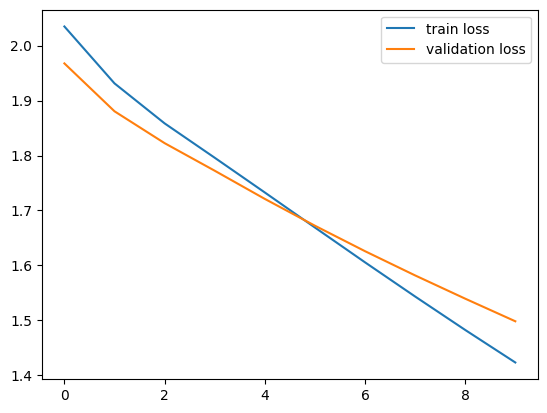

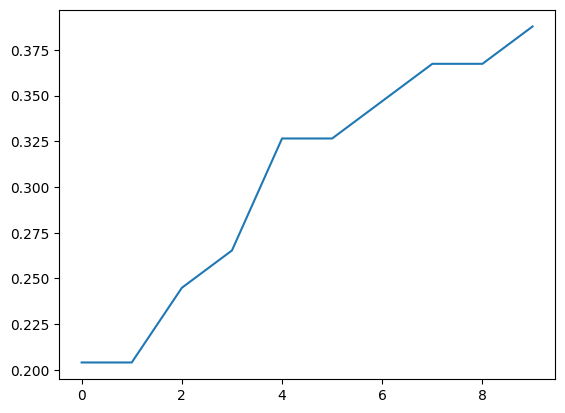

In [11]:
# To visualize the training progress, and check if
# a) the model is overfitting (training loss keeps decreasing but validation loss increases)
# b) the model is learning (loss decreases steadily)

# my_history.history is a dictionary that contains lists of metrics recorded at each epoch
# Example:
# {'loss': [0.8, 0.5, 0.3],
#  'accuracy': [0.65, 0.78, 0.85],
#  'val_loss': [0.7, 0.55, 0.35],
#  'val_accuracy': [0.68, 0.76, 0.82]}

plt.plot(my_history.history['loss'], label = 'train loss')
plt.plot(my_history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

plt.plot(my_history.history['val_accuracy'], label = 'validation accuracy')
plt.show()



Q: Should we train the model for so many epochs?

*Hint:* Look at the validation loss as well!

Q: Enjoy varying different hyperparameters before moving on

### 5. Test (moment of truth)

Let's evaluate the performance on the test set!

In [12]:
loss, accuracy = model_ffnn.evaluate(X_test_embed, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4402 - loss: 1.6701
Test Loss: 1.6876
Test Accuracy: 0.4259


Q: Are results according with the validation accuracy?

Q: Try to fill in the table provided in the lab

## RNN

RNNs process data as sequences so the order of the input is preserved now.
Let's tokenize the data and learn the embbedings within the network!

RNNs need a tokenizer to convert text into integer sequences. Each unique word gets a unique integer index.

### Tokenizing

In [13]:
# Each unique word in your dataset gets assigned an integer ID (word_index).
# Then, texts are transformed into lists of those integers (sequences).
# About the OOV: At inference/test time, if a new word is found,
# instead of ignoring it (default), it will be maped it the <OOV> token.
tokenizer = preprocessing.text.Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(X_train[0])
print(X_train_sequences[0])

Blazing orbs of fire plummet to the ground at four different points you can see within range. Each creature in a 40-foot-radius sphere centered on each point you choose must make a Dexterity saving throw. The sphere spreads around corners. A creature takes 20d6 fire damage and 20d6 bludgeoning damage on a failed save, or half as much damage on a successful one. A creature in the area of more than one fiery burst is affected only once.  The spell damages objects in the area and ignites flammable objects that aren’t being worn or carried.
[2306, 2307, 5, 116, 2308, 6, 2, 99, 32, 494, 210, 72, 4, 13, 47, 23, 41, 29, 10, 14, 3, 388, 62, 112, 117, 161, 12, 29, 79, 4, 56, 35, 44, 3, 114, 33, 38, 2, 117, 448, 228, 513, 3, 10, 53, 1714, 116, 22, 9, 1714, 244, 22, 12, 3, 75, 50, 7, 91, 24, 106, 22, 12, 3, 82, 36, 3, 10, 14, 2, 48, 5, 134, 107, 36, 1387, 912, 16, 102, 132, 218, 2, 8, 819, 173, 14, 2, 48, 9, 734, 669, 173, 15, 346, 182, 367, 7, 322]


### Padding

Notice that RNNs process sequences word by word, padding is needed for ***batch*** training (ohhhh).

Now, our sentences have different lengths and RNNs expect fixed length sequences. We need to choose a maximum lenght
 - cut longer sentences
 - pad shorter sentences with a *dummy* token to be ignored by the network

In [14]:
max_len = 200
X_train_pad = preprocessing.sequence.pad_sequences(X_train_sequences, padding='post', maxlen=max_len)
X_test_pad = preprocessing.sequence.pad_sequences(X_test_sequences, padding='post', maxlen=max_len)

Q: What do you think should be the maximum length?

*Hint:* Check the distribution of the number of words per observation! Histograms are our friends!

In [15]:
# now all (485) observations have the same length
X_train_pad.shape

(485, 200)

In [16]:
# Building the RNN

# tokenizer.word_index is a dictionary mapping words into unique integers
vocab_size = len(tokenizer.word_index) + 1 # 0 is used for padding (and that explains the +1)
print(vocab_size)

embed_dim = 512 # embeddings for each word (randomly initialized)

model_rnn = Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embed_dim),
    layers.LSTM(16),
    layers.Dense(len(unique_categories), activation='softmax')
], name="my_RNN")

# As before:
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

3978


In [17]:
# Train (as previous)
history_rnn = model_rnn.fit(X_train_pad,
                            y_train_cat,
                            validation_split =0.1,
                            epochs=5,
                            batch_size=32) # defined for clarity

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.2245 - loss: 2.0440 - val_accuracy: 0.2041 - val_loss: 1.9773
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3159 - loss: 1.9554 - val_accuracy: 0.1633 - val_loss: 1.9626
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3125 - loss: 1.9411 - val_accuracy: 0.2041 - val_loss: 1.9480
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3073 - loss: 1.9200 - val_accuracy: 0.2245 - val_loss: 1.9408
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3053 - loss: 1.8965 - val_accuracy: 0.2245 - val_loss: 1.9391


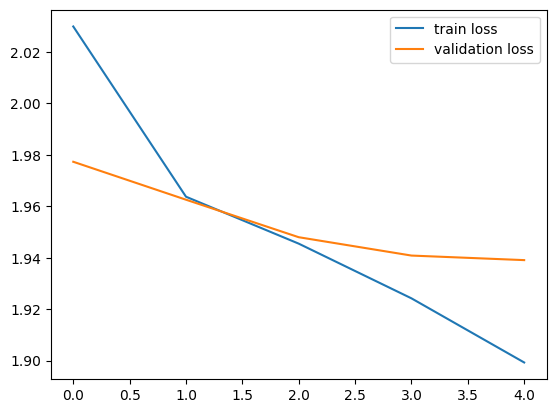

In [18]:
# Visualize
plt.plot(history_rnn.history['loss'], label = 'train loss')
plt.plot(history_rnn.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

Q: How many epochs should we train the model for?
Re-run the previous cell with your chosen number and look at the impact on test evaluation.

In [19]:
model_rnn.summary()

Model: "my_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 512)       │     2,036,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │        33,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,212,186 (23.70 MB)

 Trainable params: 2,070,728 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,141,458 (15.80 MB)

In [20]:
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2211 - loss: 2.0110
Test Loss: 2.0269
Test Accuracy: 0.2222


Note: more complex architectures don't necessarily yield better results! <br>
Special attention needs to be had when the number of samples is very low.

Q: What other strategies would you use to improve your model?

### Differences in performace

Q: Are the performance differences between RNN and FFNN statistically significant?

To answer this, we need to collect multiple performance estimates for each model. With multiple performance estimates, we can assess the variability of performance adn check whether the differences are meaningful.

To this end, we can assess NNs on different data samples (considering as well the inherent variability associated with weight initializations and batch selection).

In [21]:
accs_ffnn, accs_rnn = [], []
from tensorflow.keras.models import clone_model

# encoding text as a padded sequence of words
def sequence_pad(X):
  sequences = tokenizer.texts_to_sequences(X)
  return preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=max_len)

for train, test in model_selection.StratifiedKFold(n_splits=5).split(X,y):

  # one-hot-encoding of targets
  y_train, y_test = utils.to_categorical(y[train]), utils.to_categorical(y[test])

  # Fresh FFNN each fold
  ffnn = clone_model(model_ffnn)
  ffnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  print("\nFFNN:\n")
  model_ffnn.fit(embed(X[train]), y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)
  loss, accuracy = model_ffnn.evaluate(embed(X[test]), y_test, verbose=0)
  accs_ffnn.append(accuracy)

  # Fresh RNN each fold
  rnn = clone_model(model_rnn)
  rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  print("\nRNN:\n")
  model_rnn.fit(sequence_pad(X[train]), y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)
  loss, accuracy = model_rnn.evaluate(sequence_pad(X[test]), y_test, verbose=0)
  accs_rnn.append(accuracy)


FFNN:

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5572 - loss: 1.4173 - val_accuracy: 0.5000 - val_loss: 1.4926
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5649 - loss: 1.3665 - val_accuracy: 0.5227 - val_loss: 1.4704
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6088 - loss: 1.3204 - val_accuracy: 0.5000 - val_loss: 1.4444
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6144 - loss: 1.2698 - val_accuracy: 0.5455 - val_loss: 1.4240
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6237 - loss: 1.2227 - val_accuracy: 0.5682 - val_loss: 1.4048

RNN:

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2901 - loss: 1.9142 - val_accuracy: 0.4545 - val_loss: 1.8187
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2903 - loss: 1.8833 - val_accuracy: 0.3409 - val_loss: 1.7949
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3272 - loss: 1.8512 - val_accuracy: 0.3409 

In [22]:
accs_ffnn, accs_rnn

([0.5555555820465088,
  0.6481481194496155,
  0.7037037014961243,
  0.8148148059844971,
  0.672897219657898],
 [0.2222222238779068,
  0.29629629850387573,
  0.3055555522441864,
  0.4444444477558136,
  0.40186914801597595])

When testing superiority of one model against another from performance estimates obtained from the same folds:
- paired t-test if the samples are normally distributed
- Wilcoxon signed rank test (non-parametric version of paired t-test) otherwise

The null hypothesis (H₀) is that there are no differences between the mean performance of both samples.<br>

If a test returns a low p-value (p<0.05): one model is superior to the other, i.e. improvements are statistically significant (do not occur by chance).

In [24]:
# First: note that the sample size is very small,
# which makes these normality tests unreliable.

# Calculate the differences in accuracies
diffs = np.array(accs_ffnn) - np.array(accs_rnn)

# Are the differences normally distributed?
# we are testing the differences between pairs
p_normal_diffs = stats.shapiro(diffs)

# H0: data come from a normal distribution.
# if p_value < 0.05 then reject H0 (data are not normally distributed)
# otherwise, fail to reject H0 (data are consistent with normality)

print("Are the differences in accuracies normally distributed?")
print("Differences?", p_normal_diffs[1] < 0.05)

# As there is evidence that the differences are not normally distributed,
# we are testing whether acc(ffnn) > acc(rnn) (and, thus, the "greater") using a Wilcoxon signed-rank test
stats.wilcoxon(accs_ffnn, accs_rnn, alternative='greater')

# otherwise (if the differences were normally distributed) we would use:
# stats.ttest_rel(accs_ffnn, accs_rnn, alternative='greater')

Are the differences in accuracies normally distributed?
Differences? False


WilcoxonResult(statistic=np.float64(15.0), pvalue=np.float64(0.03125))

Conclusion: Since the p-value is far below 0.05, we reject the null hypothesis. This indicates a statistically significant difference between the two methods, with strong evidence that the mean performance of the first model is greater than that of the second.